A bridge is usually defined to be the same as an isthmus, that is, an edge whose removal increases the number of components.

Given a graph $G$ and a cycle $C$ inside it, a bridge of $C$ is a non-empty set of edges defined as follows: it is the edges of a component of $G[V(G) \setminus V(C)]$, together with any edges joining that component to $C$. A chord of $C$ is also defined to be a bridge of $C$, having a single edge. Therefore the bridges partition $E(G) \setminus E(C)$.

Notice that isolated vertices of $G$ do not feature in any bridge. However, an isolated vertex of $G[V(G) \setminus V(C)]$ which is joined to $C$ by some edges will give rise to a bridge consisting of just those edges. Hence a bridge with one edge is either a chord of $C$, or it is an edge joining a vertex of $C$ to a vertex of degree one outside $C$, or it is an edge joining two vertices of degree one both outside $C$.

The vertices of attachment of a bridge are the vertices of $C$ which are end vertices of edges in the bridge. So a bridge might have no vertices of attachment (if it is the edges of a component of $G[V (G) \setminus V (C)]$ not joined to $C$), or it might have one or more. Note that bridges can meet each other, but only at vertices of attachment

In [59]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

def find_graph_components(graph):
    '''
    Finds the connected components of a graph using breadth-first search (BFS).
    Args:
        graph: The input graph.
    Returns:
        A list where each inner list contains the nodes of a single connected component.
    '''
    all_components = []
    visited_nodes = set()

    for node in graph.nodes():
        if node not in visited_nodes:
            current_component = []
            q = deque([node])
            visited_nodes.add(node)

            while q:
                current_node = q.popleft()
                current_component.append(current_node)

                for neighbor in graph.neighbors(current_node):
                    if neighbor not in visited_nodes:
                        visited_nodes.add(neighbor)
                        q.append(neighbor)

            all_components.append(current_component)

    return all_components

def find_bridges_of_cycle(graph, cycle_nodes):
    '''
    Finds all bridges of a given cycle C in a graph G. A bridge is either:
    1. A "chord": a single edge connecting two vertices of C.
    2. A component of G remaining after deleting C, plus all edges
       connecting that component back to C.
    Args:
        graph: The full graph G.
        cycle_nodes: A list of nodes, in order, forming the cycle C.
    Returns:
        A list of bridges containing its 'edges' and its 'attachments' in C.
    '''
    bridges = []
    cycle_nodes_set = set(cycle_nodes)

    # Create a set of the cycle's edges for quick lookups
    cycle_edges = set()
    for i in range(len(cycle_nodes)):
        u, v = cycle_nodes[i], cycle_nodes[(i + 1) % len(cycle_nodes)]
        # Store edges in a canonical order (min, max)
        cycle_edges.add(tuple(sorted((u, v))))

    # Find all chords
    edges_in_bridges = set()
    for u, v in graph.edges():
        if u in cycle_nodes_set and v in cycle_nodes_set:
            edge = tuple(sorted((u, v)))
            if edge not in cycle_edges:
                # This is a chord
                bridges.append({
                    'edges': [(u, v)],
                    'attachments': sorted([u, v])
                })
                edges_in_bridges.add(edge)

    # Find component-based bridges
    # Create a subgraph containing only vertices NOT in the cycle
    external_nodes = [n for n in graph.nodes() if n not in cycle_nodes_set]
    subgraph = graph.subgraph(external_nodes)

    # Find the components of this external subgraph
    external_components = find_graph_components(subgraph)

    for component_nodes in external_components:
        component_edges = set()
        attachments = set()

        # Add edges that are entirely within the component
        for u, v in subgraph.subgraph(component_nodes).edges():
            component_edges.add(tuple(sorted((u, v))))

        # Add edges that connect this component to the main cycle
        for node in component_nodes:
            for neighbor in graph.neighbors(node):
                if neighbor in cycle_nodes_set:
                    # This is a connecting edge
                    component_edges.add(tuple(sorted((node, neighbor))))
                    attachments.add(neighbor)

        if component_edges:
            bridges.append({
                'edges': [e for e in component_edges],
                'attachments': sorted(list(attachments))
            })

    return bridges

The graph has 2 component(s).
  Component 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Component 2: [11, 13]

Found 4 bridges for cycle C.
  Bridge 1:
    Attachments: [1, 2, 3]
    Edges: [(4, 6), (1, 4), (4, 5), (5, 6), (3, 6), (2, 5)]
  Bridge 2:
    Attachments: [1]
    Edges: [(7, 9), (1, 7), (8, 9), (7, 8)]
  Bridge 3:
    Attachments: [2]
    Edges: [(2, 10)]
  Bridge 4:
    Attachments: []
    Edges: [(11, 13)]


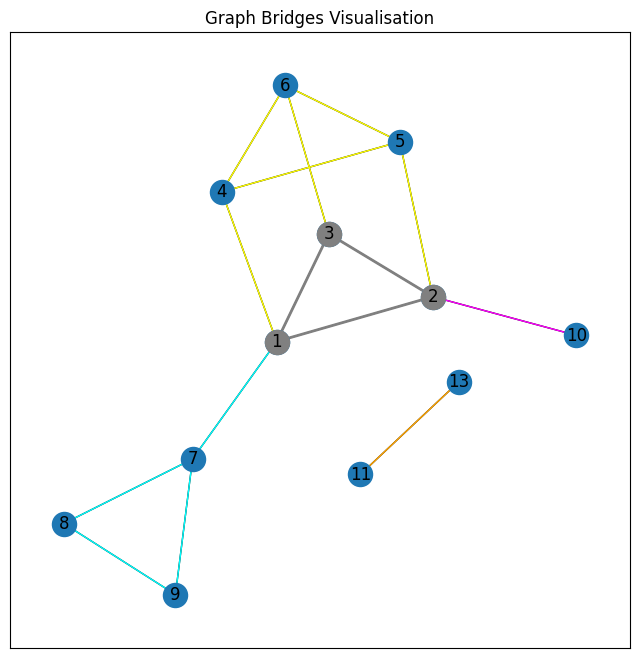

In [60]:
# This core graph is the 'prism graph' (a triangular prism).
G = nx.Graph()
G.add_edges_from([
    (1, 2), (2, 3), (3, 1), # Bottom triangle (our cycle C)
    (4, 5), (5, 6), (6, 4), # Top triangle
    (1, 4), (2, 5), (3, 6), # Edges connecting top and bottom
    (1, 7),                 # Add a component only connected to vertex 1
    (7, 8), (8, 9), (9, 7), # Add some complexity to the component
    (2, 10),                # Add a chord
    (11, 13),               # Add two vertices outside C
])

# Define the cycle C
C = [1, 2, 3]

components = find_graph_components(G)
print(f"The graph has {len(components)} component(s).")
for i, comp in enumerate(components):
    print(f"  Component {i+1}: {sorted(comp)}")

bridges = find_bridges_of_cycle(G, C)
print(f"\nFound {len(bridges)} bridges for cycle C.")
for i, bridge in enumerate(bridges):
    print(f"  Bridge {i+1}:")
    print(f"    Attachments: {bridge['attachments']}")
    print(f"    Edges: {bridge['edges']}")

plt.figure(figsize=(8, 8))
pos = nx.kamada_kawai_layout(G)

cycle_color = 'grey'
bridge_colors = ['yellow', 'cyan', 'magenta', 'orange']

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)

cycle_edges = [(C[i], C[(i + 1) % len(C)]) for i in range(len(C))]
nx.draw_networkx_edges(G, pos, edgelist=cycle_edges, edge_color=cycle_color, width=2.0)
nx.draw_networkx_nodes(G, pos, nodelist=C, node_color=cycle_color)

for i, bridge in enumerate(bridges):
    color = bridge_colors[i % len(bridge_colors)]
    nx.draw_networkx_edges(G, pos, edgelist=bridge['edges'], edge_color=color)

plt.title("Graph Bridges Visualisation")
plt.show()